In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
label = "QCRE_2D_1_atanh_NW_new"

x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

bound_pts_1 = (X == 0).reshape(-1,)
bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

xy_bound_1 = xy[bound_pts_1,:]
xy_bound_2 = xy[bound_pts_2,:]
xy_bound_3 = xy[bound_pts_3,:]
xy_bound_4 = xy[bound_pts_4,:]

u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [3]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xy_bound.shape[0], N_T, replace=False) 
    xy_BC = xy_bound[idx,:] #choose indices from  set 'idx' (x,t)
    u_BC = u_bound[idx].reshape(-1,1)      #choose corresponding u


    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [42]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + N_f*loss_f
        
        return loss_val
     
    'callable for optimizer'  
    def closure(self):
        
        optimizer.zero_grad()
        
        
        
        
        if ((ops%100) == 0):
            xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,(self.iter)*13)
            xy_coll1 = torch.from_numpy(xy_coll_np_array).float().to(device)
            xy_BC1 = torch.from_numpy(xy_BC_np_array).float().to(device)
            u_BC1 = torch.from_numpy(u_BC_np_array).float().to(device)
            f_hat1 = torch.zeros(xy_coll.shape[0],1).to(device)
            loss = self.loss(xy_BC1, u_BC1, xy_coll1,f_hat1)
        else:
            loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xy_test_tensor):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [43]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    
    torch.manual_seed(reps*36)
    N_T = 500 #Total number of data points for 'y'
    N_f = 10000 #Total number of collocation points 
    
    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,(reps)*3)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)

    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 20, 
                              max_eval = 30, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    start_time = time.time()
        
    for ops in range(5000):
        optimizer.step(PINN.closure)
        #scheduler.step(PINN.loss(xy_BC,u_BC,xy_coll,f_hat))
        
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 507126.4
1 Train Loss 494250.28
2 Train Loss 447644.25
3 Train Loss 482046.12
4 Train Loss 477629.7
5 Train Loss 492134.72
6 Train Loss 476958.0
7 Train Loss 479317.34
8 Train Loss 477984.44
9 Train Loss 477322.75
10 Train Loss 476770.38
11 Train Loss 476698.44
12 Train Loss 476642.47
1

308 Train Loss 110220.83
309 Train Loss 115023.28
310 Train Loss 110148.586
311 Train Loss 109891.41
312 Train Loss 109633.195
313 Train Loss 109456.81
314 Train Loss 109211.67
315 Train Loss 109211.67
316 Train Loss 110960.16
317 Train Loss 109145.01
318 Train Loss 109043.1
319 Train Loss 108906.5
320 Train Loss 108746.664
321 Train Loss 108677.734
322 Train Loss 108629.19
323 Train Loss 108564.07
324 Train Loss 108462.87
325 Train Loss 108265.51
326 Train Loss 108073.76
327 Train Loss 108470.32
328 Train Loss 107747.11
329 Train Loss 108876.86
330 Train Loss 107467.805
331 Train Loss 107055.74
332 Train Loss 106738.36
333 Train Loss 106580.99
334 Train Loss 106489.37
335 Train Loss 106403.164
336 Train Loss 106354.24
337 Train Loss 106259.164
338 Train Loss 106117.266
339 Train Loss 106117.266
340 Train Loss 105986.625
341 Train Loss 105669.66
342 Train Loss 105338.13
343 Train Loss 105206.51
344 Train Loss 104716.54
345 Train Loss 104634.33
346 Train Loss 104397.61
347 Train Loss 10

647 Train Loss 76836.87
648 Train Loss 76815.45
649 Train Loss 76805.82
650 Train Loss 76760.26
651 Train Loss 76760.26
652 Train Loss 76726.74
653 Train Loss 76701.18
654 Train Loss 76683.84
655 Train Loss 76669.055
656 Train Loss 76652.13
657 Train Loss 76659.305
658 Train Loss 76611.59
659 Train Loss 76536.484
660 Train Loss 76326.43
661 Train Loss 77567.54
662 Train Loss 76232.695
663 Train Loss 76935.266
664 Train Loss 76066.08
665 Train Loss 76015.54
666 Train Loss 76095.51
667 Train Loss 75861.84
668 Train Loss 76002.67
669 Train Loss 75741.48
670 Train Loss 75702.22
671 Train Loss 75616.88
672 Train Loss 75567.15
673 Train Loss 75505.445
674 Train Loss 75513.766
675 Train Loss 75412.29
676 Train Loss 75454.195
677 Train Loss 75364.35
678 Train Loss 75333.52
679 Train Loss 75295.04
680 Train Loss 75295.04
681 Train Loss 75278.93
682 Train Loss 75244.48
683 Train Loss 75247.07
684 Train Loss 75238.81
685 Train Loss 75234.29
686 Train Loss 75220.66
687 Train Loss 75206.97
688 Trai

989 Train Loss 65087.17
990 Train Loss 65087.17
991 Train Loss 65064.246
992 Train Loss 65049.438
993 Train Loss 65041.246
994 Train Loss 65013.016
995 Train Loss 64989.77
996 Train Loss 64964.637
997 Train Loss 64922.04
998 Train Loss 64891.88
999 Train Loss 64849.566
1000 Train Loss 64968.11
1001 Train Loss 64831.773
1002 Train Loss 64815.24
1003 Train Loss 64757.84
1004 Train Loss 64734.066
1005 Train Loss 64717.37
1006 Train Loss 64738.445
1007 Train Loss 64700.56
1008 Train Loss 64697.3
1009 Train Loss 64688.39
1010 Train Loss 64683.043
1011 Train Loss 64675.492
1012 Train Loss 64660.508
1013 Train Loss 64660.508
1014 Train Loss 64650.805
1015 Train Loss 64641.85
1016 Train Loss 64635.035
1017 Train Loss 64631.684
1018 Train Loss 64623.418
1019 Train Loss 64613.64
1020 Train Loss 64598.496
1021 Train Loss 64588.684
1022 Train Loss 64580.746
1023 Train Loss 64567.883
1024 Train Loss 64560.53
1025 Train Loss 64550.055
1026 Train Loss 64529.203
1027 Train Loss 64512.39
1028 Train Los

1312 Train Loss 59136.19
1313 Train Loss 59124.816
1314 Train Loss 59116.586
1315 Train Loss 59106.617
1316 Train Loss 59106.617
1317 Train Loss 59096.78
1318 Train Loss 59093.242
1319 Train Loss 59088.484
1320 Train Loss 59085.375
1321 Train Loss 59079.527
1322 Train Loss 59076.887
1323 Train Loss 59070.074
1324 Train Loss 59063.4
1325 Train Loss 59056.027
1326 Train Loss 59043.89
1327 Train Loss 59022.29
1328 Train Loss 59009.883
1329 Train Loss 58986.33
1330 Train Loss 58971.504
1331 Train Loss 58955.93
1332 Train Loss 58947.0
1333 Train Loss 58931.934
1334 Train Loss 58922.844
1335 Train Loss 58913.855
1336 Train Loss 58904.914
1337 Train Loss 58895.47
1338 Train Loss 58895.47
1339 Train Loss 58894.53
1340 Train Loss 58890.945
1341 Train Loss 58890.91
1342 Train Loss 58889.08
1343 Train Loss 58885.88
1344 Train Loss 58880.797
1345 Train Loss 58875.445
1346 Train Loss 58867.52
1347 Train Loss 58860.727
1348 Train Loss 58859.918
1349 Train Loss 58851.24
1350 Train Loss 58843.656
1351

1634 Train Loss 57525.332
1635 Train Loss 57524.902
1636 Train Loss 57524.31
1637 Train Loss 57524.31
1638 Train Loss 57523.457
1639 Train Loss 57522.45
1640 Train Loss 57521.047
1641 Train Loss 57518.797
1642 Train Loss 57515.824
1643 Train Loss 57517.043
1644 Train Loss 57514.484
1645 Train Loss 57515.625
1646 Train Loss 57513.52
1647 Train Loss 57512.582
1648 Train Loss 57511.51
1649 Train Loss 57510.47
1650 Train Loss 57510.336
1651 Train Loss 57510.125
1652 Train Loss 57509.58
1653 Train Loss 57508.7
1654 Train Loss 57507.2
1655 Train Loss 57508.062
1656 Train Loss 57505.996
1657 Train Loss 57503.64
1658 Train Loss 57501.01
1659 Train Loss 57499.652
1660 Train Loss 57499.508
1661 Train Loss 57498.348
1662 Train Loss 57498.348
1663 Train Loss 57497.527
1664 Train Loss 57496.547
1665 Train Loss 57494.49
1666 Train Loss 57493.008
1667 Train Loss 57491.59
1668 Train Loss 57489.992
1669 Train Loss 57486.703
1670 Train Loss 57482.316
1671 Train Loss 57477.688
1672 Train Loss 57476.133
1

1956 Train Loss 56506.996
1957 Train Loss 56499.027
1958 Train Loss 56493.05
1959 Train Loss 56490.098
1960 Train Loss 56487.746
1961 Train Loss 56485.484
1962 Train Loss 56482.035
1963 Train Loss 56480.023
1964 Train Loss 56477.285
1965 Train Loss 56473.316
1966 Train Loss 56470.152
1967 Train Loss 56470.152
1968 Train Loss 56468.285
1969 Train Loss 56466.793
1970 Train Loss 56464.996
1971 Train Loss 56463.53
1972 Train Loss 56461.883
1973 Train Loss 56460.46
1974 Train Loss 56459.3
1975 Train Loss 56458.406
1976 Train Loss 56457.023
1977 Train Loss 56453.543
1978 Train Loss 56449.133
1979 Train Loss 56441.28
1980 Train Loss 56435.56
1981 Train Loss 56432.54
1982 Train Loss 56428.707
1983 Train Loss 56424.22
1984 Train Loss 56420.434
1985 Train Loss 56416.793
1986 Train Loss 56412.867
1987 Train Loss 56410.684
1988 Train Loss 56410.684
1989 Train Loss 56407.8
1990 Train Loss 56401.613
1991 Train Loss 56397.914
1992 Train Loss 56389.492
1993 Train Loss 56390.062
1994 Train Loss 56384.9

2277 Train Loss 55387.574
2278 Train Loss 55382.04
2279 Train Loss 55376.805
2280 Train Loss 55375.707
2281 Train Loss 55372.07
2282 Train Loss 55366.76
2283 Train Loss 55360.023
2284 Train Loss 55354.125
2285 Train Loss 55350.73
2286 Train Loss 55341.78
2287 Train Loss 55335.09
2288 Train Loss 55328.688
2289 Train Loss 55318.637
2290 Train Loss 55308.1
2291 Train Loss 55306.16
2292 Train Loss 55312.055
2293 Train Loss 55295.125
2294 Train Loss 55287.47
2295 Train Loss 55284.035
2296 Train Loss 55278.844
2297 Train Loss 55274.805
2298 Train Loss 55274.805
2299 Train Loss 55275.69
2300 Train Loss 55272.08
2301 Train Loss 55269.73
2302 Train Loss 55270.758
2303 Train Loss 55266.73
2304 Train Loss 55265.457
2305 Train Loss 55262.67
2306 Train Loss 55260.004
2307 Train Loss 55256.34
2308 Train Loss 55251.074
2309 Train Loss 55250.547
2310 Train Loss 55248.348
2311 Train Loss 55244.35
2312 Train Loss 55238.258
2313 Train Loss 55232.258
2314 Train Loss 55230.094
2315 Train Loss 55227.54
2316

2599 Train Loss 54053.637
2600 Train Loss 54048.477
2601 Train Loss 54047.906
2602 Train Loss 54042.41
2603 Train Loss 54039.977
2604 Train Loss 54036.062
2605 Train Loss 54030.27
2606 Train Loss 54021.6
2607 Train Loss 54005.613
2608 Train Loss 54034.24
2609 Train Loss 53997.266
2610 Train Loss 53992.426
2611 Train Loss 53986.54
2612 Train Loss 53981.965
2613 Train Loss 53981.965
2614 Train Loss 53974.934
2615 Train Loss 53973.42
2616 Train Loss 53964.586
2617 Train Loss 53958.086
2618 Train Loss 53956.445
2619 Train Loss 53952.09
2620 Train Loss 53947.84
2621 Train Loss 53939.3
2622 Train Loss 53938.297
2623 Train Loss 53932.68
2624 Train Loss 53934.36
2625 Train Loss 53924.547
2626 Train Loss 53920.02
2627 Train Loss 53916.164
2628 Train Loss 53912.535
2629 Train Loss 53911.055
2630 Train Loss 53906.375
2631 Train Loss 53903.85
2632 Train Loss 53901.113
2633 Train Loss 53898.484
2634 Train Loss 53895.66
2635 Train Loss 53893.375
2636 Train Loss 53888.336
2637 Train Loss 53882.35
263

2922 Train Loss 52774.14
2923 Train Loss 52772.94
2924 Train Loss 52771.375
2925 Train Loss 52769.562
2926 Train Loss 52768.082
2927 Train Loss 52765.63
2928 Train Loss 52762.68
2929 Train Loss 52758.8
2930 Train Loss 52755.51
2931 Train Loss 52752.64
2932 Train Loss 52749.7
2933 Train Loss 52748.754
2934 Train Loss 52746.836
2935 Train Loss 52745.31
2936 Train Loss 52743.082
2937 Train Loss 52743.082
2938 Train Loss 52739.51
2939 Train Loss 52734.008
2940 Train Loss 52724.086
2941 Train Loss 52709.98
2942 Train Loss 52692.508
2943 Train Loss 52699.47
2944 Train Loss 52683.586
2945 Train Loss 52663.57
2946 Train Loss 52678.49
2947 Train Loss 52656.523
2948 Train Loss 52653.79
2949 Train Loss 52649.426
2950 Train Loss 52645.734
2951 Train Loss 52642.805
2952 Train Loss 52636.176
2953 Train Loss 52627.613
2954 Train Loss 52617.37
2955 Train Loss 52609.324
2956 Train Loss 52593.684
2957 Train Loss 52580.98
2958 Train Loss 52581.36
2959 Train Loss 52563.633
2960 Train Loss 52561.72
2961 Tr

3244 Train Loss 50534.24
3245 Train Loss 50531.633
3246 Train Loss 50527.473
3247 Train Loss 50523.07
3248 Train Loss 50519.074
3249 Train Loss 50516.734
3250 Train Loss 50514.65
3251 Train Loss 50511.64
3252 Train Loss 50509.438
3253 Train Loss 50506.05
3254 Train Loss 50503.793
3255 Train Loss 50499.645
3256 Train Loss 50494.87
3257 Train Loss 50488.66
3258 Train Loss 50483.875
3259 Train Loss 50477.812
3260 Train Loss 50472.492
3261 Train Loss 50469.37
3262 Train Loss 50469.37
3263 Train Loss 50466.73
3264 Train Loss 50461.47
3265 Train Loss 50456.438
3266 Train Loss 50451.605
3267 Train Loss 50452.203
3268 Train Loss 50449.297
3269 Train Loss 50446.688
3270 Train Loss 50444.355
3271 Train Loss 50442.164
3272 Train Loss 50438.332
3273 Train Loss 50430.684
3274 Train Loss 50423.414
3275 Train Loss 50419.574
3276 Train Loss 50416.062
3277 Train Loss 50407.707
3278 Train Loss 50399.895
3279 Train Loss 50388.63
3280 Train Loss 50364.11
3281 Train Loss 50396.93
3282 Train Loss 50347.93
3

3568 Train Loss 48730.14
3569 Train Loss 48722.504
3570 Train Loss 48708.117
3571 Train Loss 48687.266
3572 Train Loss 48662.098
3573 Train Loss 48659.184
3574 Train Loss 48650.992
3575 Train Loss 48636.18
3576 Train Loss 48639.547
3577 Train Loss 48626.523
3578 Train Loss 48624.688
3579 Train Loss 48612.07
3580 Train Loss 48596.414
3581 Train Loss 48600.87
3582 Train Loss 48587.375
3583 Train Loss 48567.562
3584 Train Loss 48558.934
3585 Train Loss 48553.53
3586 Train Loss 48529.28
3587 Train Loss 48521.934
3588 Train Loss 48511.77
3589 Train Loss 48505.99
3590 Train Loss 48499.49
3591 Train Loss 48501.938
3592 Train Loss 48490.27
3593 Train Loss 48487.62
3594 Train Loss 48484.215
3595 Train Loss 48484.215
3596 Train Loss 48482.367
3597 Train Loss 48480.645
3598 Train Loss 48478.87
3599 Train Loss 48477.03
3600 Train Loss 48475.94
3601 Train Loss 48473.195
3602 Train Loss 48468.33
3603 Train Loss 48464.727
3604 Train Loss 48461.402
3605 Train Loss 48457.695
3606 Train Loss 48453.383
3

3891 Train Loss 47111.82
3892 Train Loss 47123.676
3893 Train Loss 47105.46
3894 Train Loss 47098.23
3895 Train Loss 47092.49
3896 Train Loss 47080.707
3897 Train Loss 47071.31
3898 Train Loss 47060.258
3899 Train Loss 47060.258
3900 Train Loss 47050.895
3901 Train Loss 47073.688
3902 Train Loss 47043.45
3903 Train Loss 47038.395
3904 Train Loss 47023.055
3905 Train Loss 47011.812
3906 Train Loss 46999.43
3907 Train Loss 46983.72
3908 Train Loss 46971.586
3909 Train Loss 46963.43
3910 Train Loss 46961.613
3911 Train Loss 46955.668
3912 Train Loss 46955.844
3913 Train Loss 46953.844
3914 Train Loss 46948.547
3915 Train Loss 46937.71
3916 Train Loss 46929.957
3917 Train Loss 46922.05
3918 Train Loss 46917.207
3919 Train Loss 46914.016
3920 Train Loss 46911.336
3921 Train Loss 46909.508
3922 Train Loss 46909.508
3923 Train Loss 46905.062
3924 Train Loss 46897.477
3925 Train Loss 46893.76
3926 Train Loss 46888.57
3927 Train Loss 46894.414
3928 Train Loss 46885.445
3929 Train Loss 46881.312

4212 Train Loss 44854.84
4213 Train Loss 44849.64
4214 Train Loss 44844.33
4215 Train Loss 44835.273
4216 Train Loss 44826.438
4217 Train Loss 44819.312
4218 Train Loss 44822.023
4219 Train Loss 44815.613
4220 Train Loss 44811.688
4221 Train Loss 44808.535
4222 Train Loss 44804.855
4223 Train Loss 44804.855
4224 Train Loss 44801.523
4225 Train Loss 44793.45
4226 Train Loss 44787.742
4227 Train Loss 44782.223
4228 Train Loss 44776.273
4229 Train Loss 44770.594
4230 Train Loss 44764.06
4231 Train Loss 44758.75
4232 Train Loss 44754.594
4233 Train Loss 44751.14
4234 Train Loss 44748.805
4235 Train Loss 44745.67
4236 Train Loss 44741.555
4237 Train Loss 44738.684
4238 Train Loss 44736.56
4239 Train Loss 44732.42
4240 Train Loss 44730.266
4241 Train Loss 44727.57
4242 Train Loss 44725.92
4243 Train Loss 44725.17
4244 Train Loss 44725.17
4245 Train Loss 44724.32
4246 Train Loss 44722.637
4247 Train Loss 44721.12
4248 Train Loss 44718.82
4249 Train Loss 44714.52
4250 Train Loss 44711.742
4251

4537 Train Loss 42969.8
4538 Train Loss 42960.574
4539 Train Loss 42947.973
4540 Train Loss 42934.453
4541 Train Loss 42923.832
4542 Train Loss 42899.723
4543 Train Loss 42895.863
4544 Train Loss 42895.863
4545 Train Loss 42880.22
4546 Train Loss 42871.414
4547 Train Loss 42855.17
4548 Train Loss 42878.207
4549 Train Loss 42842.824
4550 Train Loss 42827.273
4551 Train Loss 42809.414
4552 Train Loss 42804.027
4553 Train Loss 42797.8
4554 Train Loss 42788.7
4555 Train Loss 42777.863
4556 Train Loss 42766.992
4557 Train Loss 42754.465
4558 Train Loss 43355.797
4559 Train Loss 42748.984
4560 Train Loss 42733.332
4561 Train Loss 42724.77
4562 Train Loss 42714.27
4563 Train Loss 42708.21
4564 Train Loss 42701.63
4565 Train Loss 42696.312
4566 Train Loss 42691.867
4567 Train Loss 42689.387
4568 Train Loss 42689.387
4569 Train Loss 42684.91
4570 Train Loss 42680.11
4571 Train Loss 42675.312
4572 Train Loss 42664.97
4573 Train Loss 42661.12
4574 Train Loss 42659.81
4575 Train Loss 42654.35
4576

4858 Train Loss 41149.527
4859 Train Loss 41142.46
4860 Train Loss 41133.69
4861 Train Loss 41128.062
4862 Train Loss 41122.605
4863 Train Loss 41114.953
4864 Train Loss 41114.953
4865 Train Loss 41109.258
4866 Train Loss 41102.777
4867 Train Loss 41096.375
4868 Train Loss 41088.64
4869 Train Loss 41083.516
4870 Train Loss 41077.707
4871 Train Loss 41073.61
4872 Train Loss 41065.402
4873 Train Loss 41054.125
4874 Train Loss 41042.598
4875 Train Loss 41023.992
4876 Train Loss 41011.695
4877 Train Loss 40997.94
4878 Train Loss 40985.746
4879 Train Loss 40973.88
4880 Train Loss 40967.887
4881 Train Loss 40962.39
4882 Train Loss 40954.59
4883 Train Loss 40950.29
4884 Train Loss 40947.664
4885 Train Loss 40947.664
4886 Train Loss 40944.496
4887 Train Loss 40938.367
4888 Train Loss 40933.504
4889 Train Loss 40931.105
4890 Train Loss 40927.523
4891 Train Loss 40923.71
4892 Train Loss 40920.31
4893 Train Loss 40913.45
4894 Train Loss 40905.516
4895 Train Loss 40896.793
4896 Train Loss 40891.25

5181 Train Loss 39276.082
5182 Train Loss 39277.543
5183 Train Loss 39272.734
5184 Train Loss 39271.21
5185 Train Loss 39263.55
5186 Train Loss 39262.88
5187 Train Loss 39252.96
5188 Train Loss 39249.72
5189 Train Loss 39241.51
5190 Train Loss 39234.594
5191 Train Loss 39227.496
5192 Train Loss 39223.438
5193 Train Loss 39218.684
5194 Train Loss 39217.81
5195 Train Loss 39212.48
5196 Train Loss 39205.6
5197 Train Loss 39195.164
5198 Train Loss 39179.59
5199 Train Loss 39179.59
5200 Train Loss 39167.613
5201 Train Loss 39180.766
5202 Train Loss 39161.957
5203 Train Loss 39147.957
5204 Train Loss 39131.395
5205 Train Loss 39113.363
5206 Train Loss 39097.99
5207 Train Loss 39084.613
5208 Train Loss 39077.293
5209 Train Loss 39086.3
5210 Train Loss 39062.664
5211 Train Loss 39049.96
5212 Train Loss 39040.023
5213 Train Loss 39027.164
5214 Train Loss 39021.5
5215 Train Loss 39016.426
5216 Train Loss 39012.75
5217 Train Loss 39009.9
5218 Train Loss 39006.44
5219 Train Loss 39003.832
5220 Tra

5504 Train Loss 37584.594
5505 Train Loss 37572.145
5506 Train Loss 37551.023
5507 Train Loss 37542.906
5508 Train Loss 37530.848
5509 Train Loss 37521.844
5510 Train Loss 37514.92
5511 Train Loss 37507.43
5512 Train Loss 37507.43
5513 Train Loss 37505.03
5514 Train Loss 37495.965
5515 Train Loss 37491.797
5516 Train Loss 37488.68
5517 Train Loss 37481.188
5518 Train Loss 37476.418
5519 Train Loss 37467.754
5520 Train Loss 37456.508
5521 Train Loss 37444.72
5522 Train Loss 37432.87
5523 Train Loss 37424.832
5524 Train Loss 37417.324
5525 Train Loss 37408.816
5526 Train Loss 37399.812
5527 Train Loss 37382.43
5528 Train Loss 37370.426
5529 Train Loss 37374.63
5530 Train Loss 37362.594
5531 Train Loss 37347.766
5532 Train Loss 37339.383
5533 Train Loss 37327.152
5534 Train Loss 37327.152
5535 Train Loss 37314.895
5536 Train Loss 37309.266
5537 Train Loss 37301.98
5538 Train Loss 37296.418
5539 Train Loss 37290.613
5540 Train Loss 37287.52
5541 Train Loss 37282.277
5542 Train Loss 37279.0

5827 Train Loss 36903.516
5828 Train Loss 36904.74
5829 Train Loss 36904.05
5830 Train Loss 36903.53
5831 Train Loss 36903.56
5832 Train Loss 36903.574
5833 Train Loss 36903.516
5834 Train Loss 36903.516
5835 Train Loss 36904.74
5836 Train Loss 36904.05
5837 Train Loss 36903.53
5838 Train Loss 36903.56
5839 Train Loss 36903.574
5840 Train Loss 36903.516
5841 Train Loss 36903.516
5842 Train Loss 36904.74
5843 Train Loss 36904.05
5844 Train Loss 36903.53
5845 Train Loss 36903.56
5846 Train Loss 36903.574
5847 Train Loss 36903.516
5848 Train Loss 36903.516
5849 Train Loss 36904.74
5850 Train Loss 36904.05
5851 Train Loss 36903.53
5852 Train Loss 36903.56
5853 Train Loss 36903.574
5854 Train Loss 36903.516
5855 Train Loss 36903.516
5856 Train Loss 36904.74
5857 Train Loss 36904.05
5858 Train Loss 36903.53
5859 Train Loss 36903.56
5860 Train Loss 36903.574
5861 Train Loss 36903.516
5862 Train Loss 36903.516
5863 Train Loss 36904.74
5864 Train Loss 36904.05
5865 Train Loss 36903.53
5866 Trai

6151 Train Loss 36904.004
6152 Train Loss 36905.566
6153 Train Loss 36904.965
6154 Train Loss 36904.117
6155 Train Loss 36904.11
6156 Train Loss 36904.004
6157 Train Loss 36904.004
6158 Train Loss 36905.566
6159 Train Loss 36904.965
6160 Train Loss 36904.117
6161 Train Loss 36904.11
6162 Train Loss 36904.004
6163 Train Loss 36904.004
6164 Train Loss 36905.566
6165 Train Loss 36904.965
6166 Train Loss 36904.117
6167 Train Loss 36904.11
6168 Train Loss 36904.004
6169 Train Loss 36904.004
6170 Train Loss 36905.566
6171 Train Loss 36904.965
6172 Train Loss 36904.117
6173 Train Loss 36904.11
6174 Train Loss 36904.004
6175 Train Loss 36904.004
6176 Train Loss 36905.566
6177 Train Loss 36904.965
6178 Train Loss 36904.117
6179 Train Loss 36904.11
6180 Train Loss 36904.004
6181 Train Loss 36904.004
6182 Train Loss 36905.566
6183 Train Loss 36904.965
6184 Train Loss 36904.117
6185 Train Loss 36904.11
6186 Train Loss 36904.004
6187 Train Loss 36904.004
6188 Train Loss 36905.566
6189 Train Loss 36

6470 Train Loss 36905.566
6471 Train Loss 36904.965
6472 Train Loss 36904.117
6473 Train Loss 36904.11
6474 Train Loss 36904.004
6475 Train Loss 36904.004
6476 Train Loss 36905.566
6477 Train Loss 36904.965
6478 Train Loss 36904.117
6479 Train Loss 36904.11
6480 Train Loss 36904.004
6481 Train Loss 36904.004
6482 Train Loss 36905.566
6483 Train Loss 36904.965
6484 Train Loss 36904.117
6485 Train Loss 36904.11
6486 Train Loss 36904.004
6487 Train Loss 36904.004
6488 Train Loss 36905.566
6489 Train Loss 36904.965
6490 Train Loss 36904.117
6491 Train Loss 36904.11
6492 Train Loss 36904.004
6493 Train Loss 36904.004
6494 Train Loss 36905.566
6495 Train Loss 36904.965
6496 Train Loss 36904.117
6497 Train Loss 36904.11
6498 Train Loss 36904.004
6499 Train Loss 36904.004
6500 Train Loss 36905.566
6501 Train Loss 36904.965
6502 Train Loss 36904.117
6503 Train Loss 36904.11
6504 Train Loss 36904.004
6505 Train Loss 36904.004
6506 Train Loss 36905.566
6507 Train Loss 36904.965
6508 Train Loss 36

6790 Train Loss 36904.11
6791 Train Loss 36904.004
6792 Train Loss 36904.004
6793 Train Loss 36905.566
6794 Train Loss 36904.965
6795 Train Loss 36904.117
6796 Train Loss 36904.11
6797 Train Loss 36904.004
6798 Train Loss 36904.004
6799 Train Loss 36905.566
6800 Train Loss 36904.965
6801 Train Loss 36904.117
6802 Train Loss 36904.11
6803 Train Loss 36904.004
6804 Train Loss 36904.004
6805 Train Loss 36905.566
6806 Train Loss 36904.965
6807 Train Loss 36904.117
6808 Train Loss 36904.11
6809 Train Loss 36904.004
6810 Train Loss 36904.004
6811 Train Loss 36905.566
6812 Train Loss 36904.965
6813 Train Loss 36904.117
6814 Train Loss 36904.11
6815 Train Loss 36904.004
6816 Train Loss 36904.004
6817 Train Loss 36905.566
6818 Train Loss 36904.965
6819 Train Loss 36904.117
6820 Train Loss 36904.11
6821 Train Loss 36904.004
6822 Train Loss 36904.004
6823 Train Loss 36905.566
6824 Train Loss 36904.965
6825 Train Loss 36904.117
6826 Train Loss 36904.11
6827 Train Loss 36904.004
6828 Train Loss 369

7109 Train Loss 36904.004
7110 Train Loss 36904.004
7111 Train Loss 36905.566
7112 Train Loss 36904.965
7113 Train Loss 36904.117
7114 Train Loss 36904.11
7115 Train Loss 36904.004
7116 Train Loss 36904.004
7117 Train Loss 36905.566
7118 Train Loss 36904.965
7119 Train Loss 36904.117
7120 Train Loss 36904.11
7121 Train Loss 36904.004
7122 Train Loss 36904.004
7123 Train Loss 36905.566
7124 Train Loss 36904.965
7125 Train Loss 36904.117
7126 Train Loss 36904.11
7127 Train Loss 36904.004
7128 Train Loss 36904.004
7129 Train Loss 36905.566
7130 Train Loss 36904.965
7131 Train Loss 36904.117
7132 Train Loss 36904.11
7133 Train Loss 36904.004
7134 Train Loss 36904.004
7135 Train Loss 36905.566
7136 Train Loss 36904.965
7137 Train Loss 36904.117
7138 Train Loss 36904.11
7139 Train Loss 36904.004
7140 Train Loss 36904.004
7141 Train Loss 36905.566
7142 Train Loss 36904.965
7143 Train Loss 36904.117
7144 Train Loss 36904.11
7145 Train Loss 36904.004
7146 Train Loss 36904.004
7147 Train Loss 36

7434 Train Loss 36904.324
7435 Train Loss 36904.0
7436 Train Loss 36904.0
7437 Train Loss 36904.21
7438 Train Loss 36904.53
7439 Train Loss 36904.15
7440 Train Loss 36904.324
7441 Train Loss 36904.0
7442 Train Loss 36904.0
7443 Train Loss 36904.21
7444 Train Loss 36904.53
7445 Train Loss 36904.15
7446 Train Loss 36904.324
7447 Train Loss 36904.0
7448 Train Loss 36904.0
7449 Train Loss 36904.21
7450 Train Loss 36904.53
7451 Train Loss 36904.15
7452 Train Loss 36904.324
7453 Train Loss 36904.0
7454 Train Loss 36904.0
7455 Train Loss 36904.21
7456 Train Loss 36904.53
7457 Train Loss 36904.15
7458 Train Loss 36904.324
7459 Train Loss 36904.0
7460 Train Loss 36904.0
7461 Train Loss 36904.21
7462 Train Loss 36904.53
7463 Train Loss 36904.15
7464 Train Loss 36904.324
7465 Train Loss 36904.0
7466 Train Loss 36904.0
7467 Train Loss 36904.21
7468 Train Loss 36904.53
7469 Train Loss 36904.15
7470 Train Loss 36904.324
7471 Train Loss 36904.0
7472 Train Loss 36904.0
7473 Train Loss 36904.21
7474 Tr

KeyboardInterrupt: 

In [44]:
u_pred = PINN.test(xy_test_tensor)

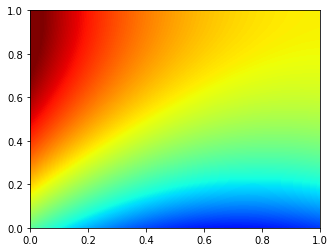

In [45]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(u_pred.reshape(500,500)),vmin = 0,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)